## This notebook is the main part of our project
### The task is to perform images classification with an as high as possible accuracy while dealing with massive unlabeled data from an unbalanced dataset. To complete the task, three general approaches are chosen and performed. We use direct learning, transfer learning and semi-supervised learning.

### Note: this notebook is combined with their results after all the training and testing are done. All the results stays the same as our presentation and report. However, there may by some errors if they are excuted. We didn't test their consistency in order to keep the origin result.

#### the first part is some general functions for direct learning and transfer learning

In [3]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import sklearn.metrics as metrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt

In [6]:
def undersampling(train_num, test_num):
    train_images = []
    test_images = []
        
    for label in label_to_id:
        indices = label_to_id[label]
            
        selected_indices = random.sample(indices, train_num + test_num)
        train_indices = selected_indices[ :train_num]
        test_indices = selected_indices[train_num : train_num + test_num]

        train_images.extend(train_indices)
        test_images.extend(test_indices)
        
    return train_images, test_images

In [7]:
class FashionDataset(Dataset):
    def __init__(self, labels, image_folder, selected_images, transform=None):
        self.labels = {key:labels[key] for key in selected_images if key in labels}
        self.image_folder = image_folder
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        keys = list(self.labels.keys())
        category = self.labels[keys[idx]]
        image_path = os.path.join(self.image_folder, f"{keys[idx]}.jpg")
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, category

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                 loss.item()))

In [9]:
def test(model, device, test_loader, array):
    model.eval()
    test_loss = 0
    correct = 0
    conf_matrix = np.zeros((8, 8)) # initialize confusion matrix
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # determine index with maximal log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # update confusion matrix
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                          target.cpu(),pred.cpu(),labels=[0,1,2,3,4,5,6,7])
        # print confusion matrix
        np.set_printoptions(precision=4, suppress=True)
        print(type(conf_matrix))
        print(conf_matrix)

    test_loss /= len(test_loader.dataset)
    array.append(round(correct / len(test_loader.dataset), 2))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

#### the next blocks are for direct learning models and results

In [2]:
# Load the CSV file with labels
a100_tag = pd.read_csv('C:/Users/FranciscoX/Desktop/fashion-dataset/a100/a100_tag.csv')
a100_path = 'C:/Users/FranciscoX/Desktop/fashion-dataset/a100/labelled'

# Create a dictionary of labels
a100_label = {}
for i in range(len(a100_tag)):
    idx = a100_tag.iloc[i, 0]
    a100_label[idx] = a100_tag.iloc[i, 2]

In [3]:
res = []
cnn = []
vgg = []

In [6]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
a100 = FashionDataset(labels=a100_label, image_folder=a100_path, selected_images=list(a100_label.keys()),
                      transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(a100))
test_size = len(a100) - train_size
train_dataset, test_dataset = random_split(a100, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Define three models, pre-trained ResNet and VGG, together with a 3-convolution-layer CNN

In [7]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNetClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)

In [8]:
# Define the H-CNN model
class HierarchicalCNN(nn.Module):
    def __init__(self, num_classes):
        super(HierarchicalCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(256*28*28, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)

In [9]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=8):
        super(VGGNet, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        self.vgg.classifier[6] = nn.Linear(4096, num_classes)
    
    def forward(self, x):
        x = self.vgg(x)
        return F.log_softmax(x, dim=1)

In [10]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model1 = ResNetClassifier(num_classes=8).to(device)
model2 = HierarchicalCNN(num_classes=8).to(device)
model3 = VGGNet(num_classes=8).to(device)

optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.5)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
optimizer3 = optim.SGD(model3.parameters(), lr=0.01, momentum=0.5)

C:\Users\FranciscoX\anaconda3\envs\pyr\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FranciscoX\anaconda3\envs\pyr\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\FranciscoX\anaconda3\envs\pyr\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Wei

the results for three models

In [15]:
# Train the Resnet model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model1, device, train_loader, optimizer1, epoch)
    test(model1, device, test_loader, res)


Train Epoch: 1 [0/1330]	Loss: 0.276911
Train Epoch: 1 [320/1330]	Loss: 0.409430
Train Epoch: 1 [640/1330]	Loss: 0.292839
Train Epoch: 1 [960/1330]	Loss: 0.163359
Train Epoch: 1 [1280/1330]	Loss: 0.206770
<class 'numpy.ndarray'>
[[66.  1.  1.  1.  0.  0.  1.  0.]
 [ 3. 52.  2.  0.  2.  0.  0.  0.]
 [ 1.  0. 37.  5.  0.  0.  5.  0.]
 [ 0.  0.  4. 14.  0.  0.  3.  0.]
 [ 0.  0.  0.  1. 67.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  1.  1.  0.  0.  0. 54.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  6.]]

Test set: Average loss: 0.3339, Accuracy: 296/333 (88.9%)

Train Epoch: 2 [0/1330]	Loss: 0.118207
Train Epoch: 2 [320/1330]	Loss: 0.164777
Train Epoch: 2 [640/1330]	Loss: 0.197026
Train Epoch: 2 [960/1330]	Loss: 0.098098
Train Epoch: 2 [1280/1330]	Loss: 0.218913
<class 'numpy.ndarray'>
[[64.  5.  1.  0.  0.  0.  0.  0.]
 [ 2. 55.  1.  0.  1.  0.  0.  0.]
 [ 1.  1. 41.  2.  0.  0.  3.  0.]
 [ 0.  1.  2. 15.  0.  0.  3.  0.]
 [ 1.  0.  0.  0. 67.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0

In [17]:
# CNN
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model2, device, train_loader, optimizer2, epoch)
    test(model2, device, test_loader, cnn)

Train Epoch: 1 [0/1330]	Loss: 2.174294
Train Epoch: 1 [320/1330]	Loss: 1.545730
Train Epoch: 1 [640/1330]	Loss: 1.063640
Train Epoch: 1 [960/1330]	Loss: 0.888354
Train Epoch: 1 [1280/1330]	Loss: 1.148375
<class 'numpy.ndarray'>
[[66.  0.  4.  0.  0.  0.  0.  0.]
 [22.  5.  1.  0. 30.  0.  1.  0.]
 [24.  0. 22.  0.  2.  0.  0.  0.]
 [ 7.  0. 13.  0.  0.  0.  1.  0.]
 [11.  0.  2.  0. 55.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [36.  0.  6.  1.  0.  0. 15.  0.]
 [ 4.  0.  4.  0.  0.  0.  0.  0.]]

Test set: Average loss: 1.3718, Accuracy: 163/333 (48.9%)

Train Epoch: 2 [0/1330]	Loss: 1.244318
Train Epoch: 2 [320/1330]	Loss: 1.078175
Train Epoch: 2 [640/1330]	Loss: 1.083902
Train Epoch: 2 [960/1330]	Loss: 0.850052
Train Epoch: 2 [1280/1330]	Loss: 0.498837
<class 'numpy.ndarray'>
[[68.  0.  1.  0.  0.  0.  1.  0.]
 [ 7. 30.  0.  0. 22.  0.  0.  0.]
 [ 7.  0. 37.  2.  1.  0.  1.  0.]
 [ 4.  0.  8.  7.  0.  0.  2.  0.]
 [ 2.  0.  0.  0. 66.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0

In [19]:
#VGG
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model3, device, train_loader, optimizer3, epoch)
    test(model3, device, test_loader, vgg)

Train Epoch: 1 [0/1330]	Loss: 2.067962
Train Epoch: 1 [320/1330]	Loss: 0.311379
Train Epoch: 1 [640/1330]	Loss: 0.526629
Train Epoch: 1 [960/1330]	Loss: 0.471783
Train Epoch: 1 [1280/1330]	Loss: 0.439187
<class 'numpy.ndarray'>
[[57.  7.  1.  1.  3.  0.  1.  0.]
 [ 2. 55.  0.  0.  2.  0.  0.  0.]
 [ 1.  0. 40.  0.  0.  0.  7.  0.]
 [ 0.  1.  8. 11.  0.  0.  1.  0.]
 [ 0.  0.  1.  0. 67.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  3.  2.  0.  1.  0. 50.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  7.]]

Test set: Average loss: 0.4594, Accuracy: 287/333 (86.2%)

Train Epoch: 2 [0/1330]	Loss: 0.345794
Train Epoch: 2 [320/1330]	Loss: 0.388444
Train Epoch: 2 [640/1330]	Loss: 0.247055
Train Epoch: 2 [960/1330]	Loss: 0.422573
Train Epoch: 2 [1280/1330]	Loss: 0.216720
<class 'numpy.ndarray'>
[[64.  2.  1.  2.  0.  0.  1.  0.]
 [ 1. 57.  0.  0.  1.  0.  0.  0.]
 [ 1.  0. 46.  0.  0.  0.  1.  0.]
 [ 0.  0.  7. 12.  0.  0.  2.  0.]
 [ 0.  0.  1.  0. 67.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0

draw plot for this part

In [28]:
pdata = {'epoch' : [1,2,3,4,5,6,7,8,9,10],
         'res' : res,
         'cnn' : cnn,
         'vgg' : vgg}
         
p = pd.DataFrame(pdata)

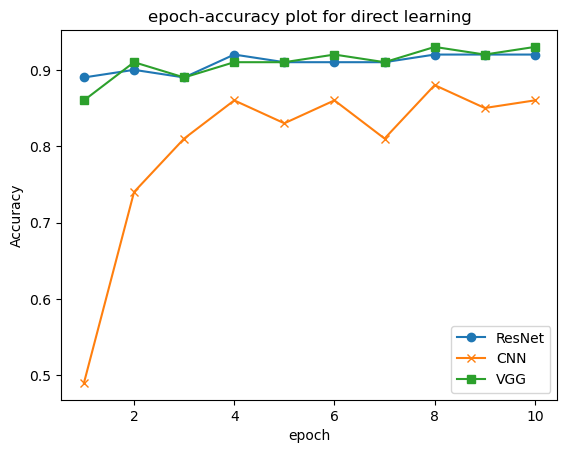

In [32]:
plt.plot(p['epoch'], p['res'], label='ResNet', marker='o')
plt.plot(p['epoch'], p['cnn'], label='CNN', marker='x')
plt.plot(p['epoch'], p['vgg'], label='VGG', marker='s')

plt.title('epoch-accuracy plot for direct learning')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

#### the next blocks are for transfer learning with MiniVGG, DenseNet-40 and ResNet-18

In [2]:
tag = pd.read_csv('C:/Users/FranciscoX/Desktop/fashion-dataset/tag.csv')
tag_set = set(tag['Label'])
tag_list = sorted(list(tag_set))
labels = {}
label_to_int = {}
for i in range(len(tag_list)):
    label_to_int[tag_list[i]] = i
for i in range(len(tag)):
    idx = tag.iloc[i, 0]
    labels[idx] = label_to_int[tag.iloc[i,2]]

label_to_id = {}
class_num = len(tag_list)
for i in range(class_num):
    label_to_id[i] = []
for id in labels:
    label_to_id[labels[id]].append(id)

In [4]:
image_folder = 'C:/Users/FranciscoX/Desktop/fashion-dataset/dataset'

transform = transforms.Compose([
    transforms.Resize(size=(80, 60)),
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
label_to_int

{'Accessories': 0,
 'Bags': 1,
 'Dress': 2,
 'Pants': 3,
 'Shoes': 4,
 'Sunglasses': 5,
 'Tops': 6,
 'Watches': 7}

define the models

In [10]:
class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout()
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 17 * 12, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(),

            nn.Linear(512, 8),
            nn.LogSoftmax(dim= -1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(in_channels)
        # 1*1 conv
        self.conv1 = nn.Conv2d(in_channels, growth_rate * 4, kernel_size=1)
        # BatchNorm2
        self.bn2 = nn.BatchNorm2d(growth_rate * 4)
        # 3*3 conv
        self.conv2 = nn.Conv2d(growth_rate * 4, growth_rate, kernel_size=3, padding=1)
    
    def forward(self, x):
        output = F.relu(self.bn1(x))  # BatchNorm1 应该在 conv1 前应用
        output = self.conv1(output)
        output = F.relu(self.bn2(output))  # BatchNorm2 应该在 conv2 前应用
        output = self.conv2(output)
        # 连接输出
        output = torch.cat([x, output], 1)
        return output

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        # Average pooling, helps reduce bias in features
        self.pool = nn.AvgPool2d(2)
    
    def forward(self, x):
        x = F.relu(self.bn(x))
        x = self.conv(x)
        return self.pool(x)    

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            # 添加 DenseLayer
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        # 将所有 DenseLayer 组合成一个顺序模块
        self.dense_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.dense_block(x)
    
class DenseNet40(nn.Module):
    def __init__(self, num_classes=8):
        super(DenseNet40, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        growth_rate = 12
        num_layers1 = 6
        num_layers2 = 12
        num_layers3 = 24

        self.block1 = DenseBlock(num_layers1, 16, growth_rate)  # 6 layers, growth rate 12
        num_features = 16 + num_layers1 * growth_rate
        self.trans1 = TransitionLayer(num_features, num_features // 2)
        
        num_features = num_features // 2
        self.block2 = DenseBlock(num_layers2, num_features, growth_rate)  # 12 layers, growth rate 12
        num_features = num_features + num_layers2 * growth_rate
        self.trans2 = TransitionLayer(num_features, num_features // 2)
        
        num_features = num_features // 2
        self.block3 = DenseBlock(num_layers3, num_features, growth_rate)  # 24 layers, growth rate 12
        num_features = num_features + num_layers3 * growth_rate
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_features, num_classes)  # 最终分类层
        self.log_softmax = nn.LogSoftmax(dim= 1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.trans1(x)
        x = self.block2(x)
        x = self.trans2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.fc(x)
        x = self.log_softmax(x)
        return x

In [12]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=8):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion * 2 * 2, num_classes)
        self.log_softmax = nn.LogSoftmax(dim= 1)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.log_softmax(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

---

In [13]:
vgg_p = []
dense_p = []
res_p = []
vgg = []
dense = []
res = []

set the numbers for undersampling, train and test the three models at the same time

In [14]:
train_num = 800
test_num = 100

In [15]:
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net1 = MiniVGG().to(device)
net2 = DenseNet40().to(device)
net3 = ResNet18().to(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

In [17]:
for param in net1.conv.parameters():
    param.requires_grad = True

for param in net2.parameters():
    param.requires_grad = True

for param in net3.parameters():
    param.requires_grad = True

optimizer1 = optim.SGD(net1.parameters(), lr=0.01, momentum=0.5)
optimizer2 = optim.SGD(net2.parameters(), lr=0.01, momentum=0.5)
optimizer3 = optim.SGD(net3.parameters(), lr=0.01, momentum=0.5)
    
for epoch in range(1, epochs + 1):
    train_images, test_images = undersampling(train_num, test_num)

    train_set = FashionDataset(labels=labels, image_folder=image_folder, selected_images = train_images,  transform=transform)
    test_set = FashionDataset(labels=labels, image_folder=image_folder, selected_images = test_images,  transform=transform)

    train_loader = DataLoader(train_set, batch_size = 64, shuffle=True)
    test_loader = DataLoader(test_set, batch_size = 64, shuffle=False)

        
    print(f'\nEpoch {epoch} for VGGmini\n') 
    train(net1, device, train_loader, optimizer1, epoch)
    test(net1, device, test_loader, vgg_p)

    print(f'\nEpoch {epoch} for DenseNet-40\n') 
    train(net2, device, train_loader, optimizer2, epoch)
    test(net2, device, test_loader, dense_p)

    print(f'\nEpoch {epoch} for ResNet18\n') 
    train(net3, device, train_loader, optimizer3, epoch)
    test(net3, device, test_loader, res_p)


Epoch 1 for VGGmini

Train Epoch: 1 [0/6400]	Loss: 0.113447
Train Epoch: 1 [640/6400]	Loss: 0.033911
Train Epoch: 1 [1280/6400]	Loss: 0.338364
Train Epoch: 1 [1920/6400]	Loss: 0.068457
Train Epoch: 1 [2560/6400]	Loss: 0.071935
Train Epoch: 1 [3200/6400]	Loss: 0.124538
Train Epoch: 1 [3840/6400]	Loss: 0.081635
Train Epoch: 1 [4480/6400]	Loss: 0.153539
Train Epoch: 1 [5120/6400]	Loss: 0.036916
Train Epoch: 1 [5760/6400]	Loss: 0.030518
<class 'numpy.ndarray'>
[[ 99.   1.   0.   0.   0.   0.   0.   0.]
 [  7.  92.   0.   0.   1.   0.   0.   0.]
 [  0.   0.  96.   1.   0.   0.   3.   0.]
 [  0.   0.   0. 100.   0.   0.   0.   0.]
 [  1.   1.   0.   0.  98.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 100.   0.   0.]
 [  3.   0.   5.   0.   0.   0.  92.   0.]
 [  1.   0.   0.   0.   0.   1.   0.  98.]]

Test set: Average loss: 0.0867, Accuracy: 775/800 (97%)


Epoch 1 for DenseNet-40

Train Epoch: 1 [0/6400]	Loss: 0.235173
Train Epoch: 1 [640/6400]	Loss: 0.188612
Train Epoch: 1 [1280/6400]	Lo

-------

draw the plot for feature learning

In [61]:
pdata = {'epoch' : list(range(1,21)),
         'vgg' : vgg_p,
         'dense' : dense_p,
         'res' : res_p}         
p = pd.DataFrame(pdata)

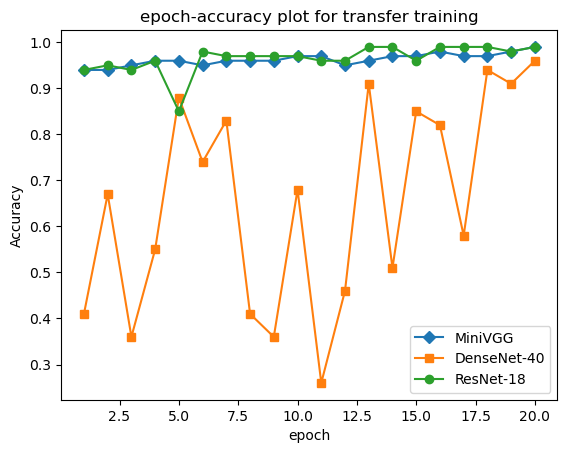

In [63]:
plt.plot(p['epoch'], p['vgg'], label='MiniVGG', marker='D')
plt.plot(p['epoch'], p['dense'], label='DenseNet-40', marker='s')
plt.plot(p['epoch'], p['res'], label='ResNet-18', marker='o')

plt.title('epoch-accuracy plot for transfer training')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

Then we do transfer learning, change the dataset every epoch with 0.8/0.2 split

In [4]:
a100_tag = pd.read_csv('C:/Users/FranciscoX/Desktop/fashion-dataset/a100/a100_tag.csv')
a100_path = 'C:/Users/FranciscoX/Desktop/fashion-dataset/a100/labelled'

In [5]:
a100_label = {}
for i in range(len(a100_tag)):
    idx = a100_tag.iloc[i, 0]
    a100_label[idx] = a100_tag.iloc[i,2]

In [42]:
a100 = FashionDataset(labels=a100_label, image_folder=a100_path, selected_images = list(a100_label.keys()),  transform=transform)

In [43]:
train_size = int(0.8 * len(a100))
test_size = len(a100) - train_size

In [44]:
for param in net1.conv.parameters():
    param.requires_grad = False

for param in net2.parameters():
    param.requires_grad = False
for param in net2.fc.parameters():
    param.requires_grad = True

for param in net3.parameters():
        param.requires_grad = False
for name, param in net3.named_parameters():
    if 'linear' in name:
        param.requires_grad = True


optimizer1 = optim.SGD(net1.parameters(), lr=0.01, momentum=0.5)
optimizer2 = optim.SGD(net2.parameters(), lr=0.01, momentum=0.5)
optimizer3 = optim.SGD(net3.parameters(), lr=0.01, momentum=0.5)
    
for epoch in range(1, 6):
    train_dataset, test_dataset = random_split(a100, [train_size, test_size])

    a_train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
    a_test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)
      
    print(f'Epoch {epoch} for VGGmini\n') 
    train(net1, device, a_train_loader, optimizer1, epoch)
    test(net1, device, a_test_loader, vgg)

    print(f'Epoch {epoch} for DenseNet-40\n') 
    train(net2, device, a_train_loader, optimizer2, epoch)
    test(net2, device, a_test_loader, dense)
    
    print(f'Epoch {epoch} for ResNet18\n') 
    train(net2, device, a_train_loader, optimizer3, epoch)
    test(net2, device, a_test_loader, res)

Epoch 1 for VGGmini

Train Epoch: 1 [0/1330]	Loss: 1.800122
Train Epoch: 1 [640/1330]	Loss: 0.713834
Train Epoch: 1 [1000/1330]	Loss: 0.784391
<class 'numpy.ndarray'>
[[68.  3.  5.  4.  1.  1.  1.  1.]
 [ 0. 57.  1.  0.  1.  0.  0.  0.]
 [ 2.  0. 32.  3.  0.  0.  1.  0.]
 [ 2.  0.  6. 16.  0.  0.  2.  0.]
 [ 0.  0.  0.  0. 55.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 7.  1.  9.  1.  0.  0. 42.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  9.]]

Test set: Average loss: 0.6967, Accuracy: 279/333 (84%)

Epoch 1 for DenseNet-40

Train Epoch: 1 [0/1330]	Loss: 1.220646
Train Epoch: 1 [640/1330]	Loss: 1.324506
Train Epoch: 1 [1000/1330]	Loss: 1.278740
<class 'numpy.ndarray'>
[[45. 11.  4.  3.  8.  6.  2.  5.]
 [16. 33.  2.  0.  3.  0.  4.  1.]
 [ 1.  2. 24.  5.  0.  0.  5.  1.]
 [ 2.  3.  4. 13.  0.  0.  4.  0.]
 [ 1.  1.  1.  0. 51.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 8.  6. 10.  4.  0.  0. 33.  0.]
 [ 0.  0.  1.  0.  3.  0.  0.  6.]]

Test set: Average loss: 1.4951, Accuracy:

draw plot for the final results

In [52]:
pdata = {'epoch' : list(range(1,6)),
         'vgg' : vgg,
         'dense' : dense,
         'res' : res}         
p = pd.DataFrame(pdata)

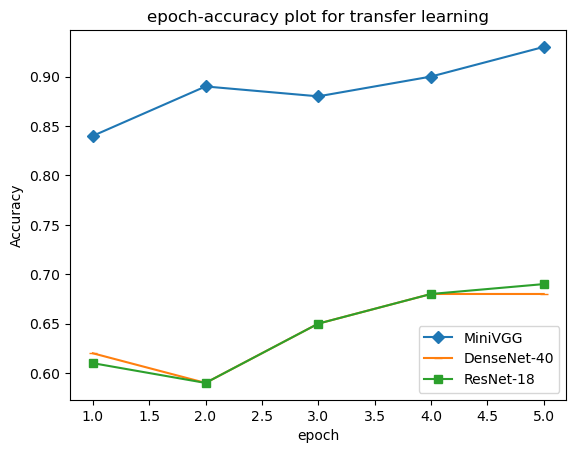

In [60]:
plt.plot(p['epoch'], p['vgg'], label='MiniVGG', marker='D')
plt.plot(p['epoch'], p['dense'], label='DenseNet-40', marker='_')
plt.plot(p['epoch'], p['res'], label='ResNet-18', marker='s')

plt.title('epoch-accuracy plot for transfer learning')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

#### the next blocks are for modified MiniVGG as H-CNN

In [20]:
def train1(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output1, output2 = model(data)
        
        loss1 = F.nll_loss(output1, target)
        loss2 = F.nll_loss(output2, target)
        
        total_loss = loss1 + loss2
        
        total_loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss1: {:.6f}\tLoss2: {:.6f}\tTotal Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss1.item(), loss2.item(), total_loss.item()))

In [21]:
def train2(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output1, output2 = model(data)
        
        loss1 = F.nll_loss(output1, target)
        loss2 = F.nll_loss(output2, target)
        
        total_loss = loss1 + loss2
        
        # use loss2 to do optimize
        loss2.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss1: {:.6f}\tLoss2: {:.6f}\tTotal Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss1.item(), loss2.item(), total_loss.item()))

In [8]:
def test(model, device, test_loader, array1, array2):
    model.eval()
    test_loss1 = 0
    test_loss2 = 0
    correct1 = 0
    correct2 = 0
    conf_matrix1 = np.zeros((8, 8))  # initialize confusion matrix for output1
    conf_matrix2 = np.zeros((8, 8))  # initialize confusion matrix for output2
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output1, output2 = model(data)
            
            # sum up batch loss for both outputs
            test_loss1 += F.nll_loss(output1, target, reduction='sum').item()
            test_loss2 += F.nll_loss(output2, target, reduction='sum').item()
            
            # calculate accuracy and update confusion matrix for output1
            pred1 = output1.argmax(dim=1, keepdim=True)
            correct1 += pred1.eq(target.view_as(pred1)).sum().item()
            conf_matrix1 += metrics.confusion_matrix(target.cpu(), pred1.cpu(), labels=[0, 1, 2, 3, 4, 5, 6, 7])
            
            # calculate accuracy and update confusion matrix for output2
            pred2 = output2.argmax(dim=1, keepdim=True)
            correct2 += pred2.eq(target.view_as(pred2)).sum().item()
            conf_matrix2 += metrics.confusion_matrix(target.cpu(), pred2.cpu(), labels=[0, 1, 2, 3, 4, 5, 6, 7])
        
        #process the first output matrix to fit 4 classes
        m1 = np.zeros((8, 4))
        for j in range(8):
            m1[j,0] = conf_matrix1[j,1]
            m1[j,1] = conf_matrix1[j,2] + conf_matrix1[j,3] + conf_matrix1[j,6]
            m1[j,2] = conf_matrix1[j,0] + conf_matrix1[j,5] + conf_matrix1[j,7]
            m1[j,3] = conf_matrix1[j,4]
        m2 = np.zeros((4, 4))
        for i in range(4):
            m2[0,i] = m1[1,i]
            m2[1,i] = m1[2,i] + m1[3,i] + m1[6,i]
            m2[2,i] = m1[0,i] + m1[5,i] + m1[7,i]
            m2[3,i] = m1[4,i]
        correct1 = int(m2[0,0] + m2[1,1] + m2[2,2] + m2[3,3])
        
        
        # print confusion matrices
        np.set_printoptions(precision=4, suppress=True)
        print("Confusion Matrix for Output1:")
        print(m2)
        print("Confusion Matrix for Output2:")
        print(conf_matrix2)

    # test_loss1 /= len(test_loader.dataset)
    test_loss2 /= len(test_loader.dataset)
    array1.append(round(correct1 / len(test_loader.dataset), 2))
    array2.append(round(correct2 / len(test_loader.dataset), 2))

    print('\nTest set for Output1: Accuracy: {}/{} ({:.1f}%)\n'.format(
        correct1, len(test_loader.dataset),
        100. * correct1 / len(test_loader.dataset)))

    print('Test set for Output2: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss2, correct2, len(test_loader.dataset),
        100. * correct2 / len(test_loader.dataset)))

In [9]:
class HMiniVGG(nn.Module):
    def __init__(self):
        super(HMiniVGG, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout()
        )

        self.classifier1 = nn.Sequential(
            nn.Linear(32 * 38 * 28, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(),

            nn.Linear(512, 8),
            nn.LogSoftmax(dim= -1)
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(64 * 17 * 12, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(),

            nn.Linear(512, 8),
            nn.LogSoftmax(dim= -1)
        )

    def forward(self, x):
        x = self.conv1(x)
        out1 = x.view(x.size(0), -1)
        out1 = self.classifier1(out1)

        x = self.conv2(x)
        out2 = x.view(x.size(0), -1)
        out2 = self.classifier2(out2)
        return out1, out2

---

In [22]:
four_p = []
eight_p = []

In [12]:
train_num = 800
test_num = 100

epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HMiniVGG().to(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

In [23]:
for param in model.conv1.parameters():
    param.requires_grad = True
for param in model.conv2.parameters():
    param.requires_grad = True

optimizer1 = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    
for epoch in range(1, epochs + 1):
    train_images, test_images = undersampling(train_num, test_num)

    train_set = FashionDataset(labels=labels, image_folder=image_folder, selected_images = train_images,  transform=transform)
    test_set = FashionDataset(labels=labels, image_folder=image_folder, selected_images = test_images,  transform=transform)

    train_loader = DataLoader(train_set, batch_size = 64, shuffle=True)
    test_loader = DataLoader(test_set, batch_size = 64, shuffle=False)

    train1(model, device, train_loader, optimizer1, epoch)
    test(model, device, test_loader, four_p, eight_p)

Train Epoch: 1 [0/6400]	Loss1: 2.407275	Loss2: 0.173256	Total Loss: 2.580531
Train Epoch: 1 [640/6400]	Loss1: 0.311655	Loss2: 0.096222	Total Loss: 0.407877
Train Epoch: 1 [1280/6400]	Loss1: 0.230477	Loss2: 0.089512	Total Loss: 0.319989
Train Epoch: 1 [1920/6400]	Loss1: 0.246382	Loss2: 0.072254	Total Loss: 0.318636
Train Epoch: 1 [2560/6400]	Loss1: 0.259277	Loss2: 0.111937	Total Loss: 0.371215
Train Epoch: 1 [3200/6400]	Loss1: 0.272428	Loss2: 0.128673	Total Loss: 0.401101
Train Epoch: 1 [3840/6400]	Loss1: 0.148695	Loss2: 0.084331	Total Loss: 0.233025
Train Epoch: 1 [4480/6400]	Loss1: 0.178577	Loss2: 0.283342	Total Loss: 0.461920
Train Epoch: 1 [5120/6400]	Loss1: 0.202963	Loss2: 0.140964	Total Loss: 0.343927
Train Epoch: 1 [5760/6400]	Loss1: 0.055489	Loss2: 0.030445	Total Loss: 0.085934
Confusion Matrix for Output1:
[[ 98.   1.   1.   0.]
 [  1. 293.   6.   0.]
 [  0.   3. 297.   0.]
 [  0.   0.   4.  96.]]
Confusion Matrix for Output2:
[[ 89.   0.   0.   0.   0.   0.   3.   8.]
 [  1.  

-----

In [24]:
pdata = {'epoch' : list(range(1,11)),
         '4' : four_p,
         '8' : eight_p}         
p1 = pd.DataFrame(pdata)

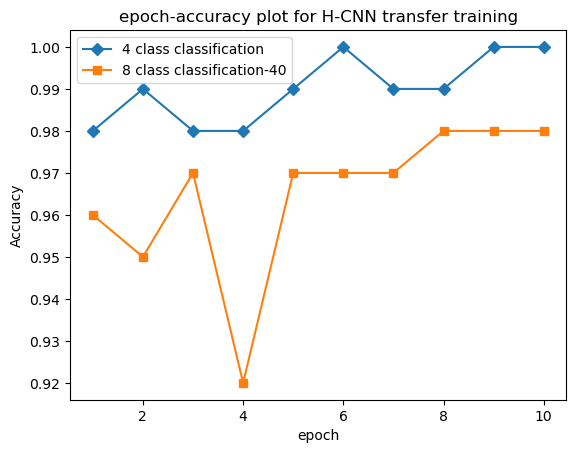

In [25]:
plt.plot(p1['epoch'], p1['4'], label='4 class classification', marker='D')
plt.plot(p1['epoch'], p1['8'], label='8 class classification', marker='s')

plt.title('epoch-accuracy plot for H-CNN transfer training')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [31]:
four = []
eight = []

In [32]:
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.conv2.parameters():
    param.requires_grad = False

optimizer1 = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    
for epoch in range(1, 6):
    train_dataset, test_dataset = random_split(a100, [train_size, test_size])

    a_train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
    a_test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)
    
    train1(model, device, a_train_loader, optimizer1, epoch)
    test(model, device, a_test_loader, four, eight)

Train Epoch: 1 [0/1330]	Loss1: 1.237029	Loss2: 0.091664	Total Loss: 1.328693
Train Epoch: 1 [640/1330]	Loss1: 0.437412	Loss2: 0.126975	Total Loss: 0.564388
Train Epoch: 1 [1000/1330]	Loss1: 0.685757	Loss2: 0.196656	Total Loss: 0.882414
Confusion Matrix for Output1:
[[ 55.   2.   1.   2.]
 [  4. 119.   7.   0.]
 [  3.   7.  71.   0.]
 [  0.   0.   0.  62.]]
Confusion Matrix for Output2:
[[72.  0.  0.  0.  0.  0.  2.  0.]
 [ 0. 59.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. 33.  2.  0.  0.  2.  0.]
 [ 0.  0.  0. 21.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 62.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0. 71.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  6.]]

Test set for Output1: Accuracy: 307/333 (92.2%)

Test set for Output2: Average loss: 0.0882, Accuracy: 324/333 (97.3%)

Train Epoch: 2 [0/1330]	Loss1: 0.199996	Loss2: 0.085277	Total Loss: 0.285273
Train Epoch: 2 [640/1330]	Loss1: 0.293570	Loss2: 0.200761	Total Loss: 0.494331
Train Epoch: 2 [1000/1330]	Loss1: 0.255748	Loss2: 0.1

I must have forgotten to save the result for this plot, but the plot can be found in the report

In [ ]:
pdata = {'epoch' : list(range(1,11)),
         '4' : four,
         '8' : eight}         
p2 = pd.DataFrame(pdata)

In [ ]:
plt.plot(p2['epoch'], p2['4'], label='4 class classification', marker='D')
plt.plot(p2['epoch'], p2['8'], label='8 class classification', marker='s')

plt.title('epoch-accuracy plot for H-CNN transfer training')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

#### the final part is for semi-supervised learning, most of the blocks were initially in '.py' files, so there is no running result in the notebook. 

the first part is from "data_split.py"

In [ ]:
import os
import json
import random

from PIL import Image
from collections import defaultdict

label = {'Bags': 'Bags',
         'Bracelet': 'Accessories',
         'Dress': 'Dress',
         'Earing': 'Accessories',
         'Hat': 'Accessories',
         'Neckline': 'Accessories',
         'Outwear': 'Tops',
         'Pants': 'Pants',
         'Shoes': 'Shoes',
         'Skirt': 'Dress',
         'Sunglasses': 'Sunglasses',
         'Top': 'Tops',
         'Watches': 'Watches'}

def extract_labels_from_json(json_path):
    with open(json_path, "r") as file:
        data = json.load(file)
    
    labels = defaultdict(list)
    for item in data:
        for img_id in item['question']:
            category, img_num = img_id.split('_')
            labels[category].append(img_num)
        for img_id in item['answers']:
            category, img_num = img_id.split('_')
            labels[category].append(img_num)

    return labels

def resize_and_save_image(src_path, dest_path, size=(32, 32)):
    with Image.open(src_path) as img:
        img = img.resize(size, Image.LANCZOS)
        img.save(dest_path)

def move_images_to_folders(images_folder, labels, destination_folder, train_ratio=0.8):
    all_images = set(os.listdir(images_folder))
    train_images, test_images = defaultdict(list), defaultdict(list)
    train_image_names, test_image_names = [], []

    for category, img_names in labels.items():
        random.shuffle(img_names)
        for i in range(len(img_names)):
            img_names[i] = img_names[i] + ".jpg"
        split_point = int(len(img_names) * train_ratio)
        train_images[category] = img_names[:split_point]
        test_images[category] = img_names[split_point:]
        train_image_names.extend(img_names[:split_point])
        test_image_names.extend(img_names[split_point:])

    for category, img_names in train_images.items():
        dest_folder = os.path.join(destination_folder, "train", label[category])
        for img_filename in img_names:
            img_path = os.path.join(images_folder, img_filename)
            dest_path = os.path.join(dest_folder, img_filename)
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)
            if os.path.exists(img_path):
                resize_and_save_image(img_path, dest_path)
            else:
                print(f"Image {img_path} not found.")

    for category, img_names in test_images.items():
        dest_folder = os.path.join(destination_folder, "test", label[category])
        for img_filename in img_names:
            img_path = os.path.join(images_folder, img_filename)
            dest_path = os.path.join(dest_folder, img_filename)
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)
            if os.path.exists(img_path):
                resize_and_save_image(img_path, dest_path)
            else:
                print(f"Image {img_path} not found.")

    # Move unlabelled images to the "unlabelled" folder
    unlabelled_images = all_images - set(train_image_names) - set(test_image_names)
    unlabelled_folder_path = os.path.join(destination_folder, "unlabelled")
    for img_filename in unlabelled_images:
        img_path = os.path.join(images_folder, img_filename)
        dest_path = os.path.join(unlabelled_folder_path, img_filename)
        if not os.path.exists(unlabelled_folder_path):
            os.makedirs(unlabelled_folder_path)
        if os.path.exists(img_path) and img_filename.split('.')[1] == 'jpg':
            resize_and_save_image(img_path, dest_path)
        else:
            print(f"Image {img_path} not found.")

def main():
    lat_json_path = "【AiDLab】A100/LAT/label/LAT.json" 
    lat_images_folder = "【AiDLab】A100/LAT/image" 
    lat_destination_folder = "datasets/LAT"
    # aat_json_path = "【AiDLab】A100/AAT/label/AAT.json" 
    # aat_images_folder = "【AiDLab】A100/AAT/image" 
    # aat_destination_folder = "datasets/AAT"

    if not os.path.exists(lat_destination_folder):
        os.makedirs(lat_destination_folder)
    # if not os.path.exists(aat_destination_folder):
    #     os.makedirs(aat_destination_folder)

    lat_labels = extract_labels_from_json(lat_json_path)
    # aat_labels = extract_labels_from_json(aat_json_path)

    move_images_to_folders(lat_images_folder, lat_labels, lat_destination_folder, train_ratio=0.6)
    # move_images_to_folders(aat_images_folder, aat_labels, aat_destination_folder, train_ratio=0.8)

    print("Split successfully.")

if __name__ == "__main__":
    main()

'mydataset.py' is to generate the dataset

In [ ]:
import os
import math
import json

import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from randaugment import RandAugmentMC

lat_mean=[0.485, 0.456, 0.406]
lat_std=[0.229, 0.224, 0.225]

def hello():
    print("Hello from data extraction!")

def get_lat(args, root):
    labelled_train_image_dir = os.path.join(root, 'datasets/LAT/train')
    test_image_dir = os.path.join(root, 'datasets/LAT/test')
    unlabelled_image_dir = os.path.join(root, 'datasets/LAT/unlabelled')

    transform_labeled = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=32,
                              padding=int(32*0.125),
                              padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(mean=lat_mean, std=lat_std)
    ])
    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=lat_mean, std=lat_std)
    ])

    labelled_train_dataset = datasets.ImageFolder(root=labelled_train_image_dir, transform=transform_labeled)
    test_dataset = datasets.ImageFolder(root=test_image_dir, transform=transform_val)
    unlabelled_train_dataset = LAT_SSL_unlabelled(
        root=unlabelled_image_dir, 
        transform=TransformFixMatch(mean=lat_mean, std=lat_std))

    return labelled_train_dataset, unlabelled_train_dataset, test_dataset

class TransformFixMatch(object):
    def __init__(self, mean, std, size = 32):
        self.weak = transforms.Compose([
            transforms.Resize(size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32,
                                  padding=int(32*0.125),
                                  padding_mode='reflect')])
        self.strong = transforms.Compose([
            transforms.Resize(size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32,
                                  padding=int(32*0.125),
                                  padding_mode='reflect'),
            RandAugmentMC(n=2, m=10)])
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)

class LAT_SSL_unlabelled(Dataset):
    def __init__(self, root, transform=None):
        self.image_files = [os.path.join(root, f) for f in os.listdir(root)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, -1 

DATASET_GETTERS = {'lat': get_lat}

'train.py' is to train the semi-supervised learning model

In [ ]:
import argparse
import logging
import math
import os
import random
import shutil
import time
from collections import OrderedDict

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from mydataset import DATASET_GETTERS
from utils import AverageMeter, confusion_matrix, accuracy

logger = logging.getLogger(__name__)
best_acc = 0

def save_checkpoint(state, is_best, checkpoint, filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint,
                                               'model_best.pth.tar'))


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps,
                                    num_training_steps,
                                    num_cycles=7./16.,
                                    last_epoch=-1):
    def _lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        no_progress = float(current_step - num_warmup_steps) / \
            float(max(1, num_training_steps - num_warmup_steps))
        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)


def interleave(x, size):
    s = list(x.shape)
    return x.reshape([-1, size] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])


def de_interleave(x, size):
    s = list(x.shape)
    return x.reshape([size, -1] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])


def main():
    parser = argparse.ArgumentParser(description='PyTorch FixMatch Training')
    parser.add_argument('--gpu-id', default='0', type=int,
                        help='id(s) for CUDA_VISIBLE_DEVICES')
    parser.add_argument('--num-workers', type=int, default=4,
                        help='number of workers')
    parser.add_argument('--dataset', default='lat', type=str,
                        choices=['lat'],
                        help='dataset name')
    parser.add_argument('--num-labeled', type=int, default=400,
                        help='number of labeled data')
    parser.add_argument("--expand-labels", action="store_true",
                        help="expand labels to fit eval steps")
    parser.add_argument('--arch', default='wideresnet', type=str,
                        choices=['wideresnet', 'resnext'],
                        help='dataset name')
    parser.add_argument('--total-steps', default=2**14, type=int,
                        help='number of total steps to run')
    parser.add_argument('--eval-step', default=512, type=int,
                        help='number of eval steps to run')
    parser.add_argument('--start-epoch', default=0, type=int,
                        help='manual epoch number (useful on restarts)')
    parser.add_argument('--batch-size', default=64, type=int,
                        help='train batchsize')
    parser.add_argument('--lr', '--learning-rate', default=0.03, type=float,
                        help='initial learning rate')
    parser.add_argument('--warmup', default=0, type=float,
                        help='warmup epochs (unlabeled data based)')
    parser.add_argument('--wdecay', default=5e-4, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', action='store_true', default=True,
                        help='use nesterov momentum')
    parser.add_argument('--use-ema', action='store_true', default=True,
                        help='use EMA model')
    parser.add_argument('--ema-decay', default=0.999, type=float,
                        help='EMA decay rate')
    parser.add_argument('--mu', default=7, type=int,
                        help='coefficient of unlabeled batch size')
    parser.add_argument('--lambda-u', default=1, type=float,
                        help='coefficient of unlabeled loss')
    parser.add_argument('--T', default=1, type=float,
                        help='pseudo label temperature')
    parser.add_argument('--threshold', default=0.95, type=float,
                        help='pseudo label threshold')
    parser.add_argument('--out', default='result',
                        help='directory to output the result')
    parser.add_argument('--resume', default='', type=str,
                        help='path to latest checkpoint (default: none)')
    parser.add_argument('--seed', default=None, type=int,
                        help="random seed")
    parser.add_argument("--opt_level", type=str, default="O1",
                        help="apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                        "See details at https://nvidia.github.io/apex/amp.html")
    parser.add_argument("--local_rank", type=int, default=-1,
                        help="For distributed training: local_rank")
    parser.add_argument('--no-progress', action='store_true',
                        help="don't use progress bar")

    args = parser.parse_args()
    global best_acc

    def create_model(args):
        if args.arch == 'wideresnet':
            import models.wideresnet as models
            model = models.build_wideresnet(depth=args.model_depth,
                                            widen_factor=args.model_width,
                                            dropout=0,
                                            num_classes=args.num_classes)
        elif args.arch == 'resnext':
            import models.resnext as models
            model = models.build_resnext(cardinality=args.model_cardinality,
                                         depth=args.model_depth,
                                         width=args.model_width,
                                         num_classes=args.num_classes)
        logger.info("Total params: {:.2f}M".format(
            sum(p.numel() for p in model.parameters())/1e6))
        return model

    if args.local_rank == -1:
        device = torch.device('cuda', args.gpu_id)
        args.world_size = 1
        args.n_gpu = torch.cuda.device_count()
    else:
        torch.cuda.set_device(args.local_rank)
        device = torch.device('cuda', args.local_rank)
        torch.distributed.init_process_group(backend='nccl')
        args.world_size = torch.distributed.get_world_size()
        args.n_gpu = 1

    args.device = device

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN)

    logger.warning(
        f"Process rank: {args.local_rank}, "
        f"device: {args.device}, "
        f"n_gpu: {args.n_gpu}, "
        f"distributed training: {bool(args.local_rank != -1)}, ",)

    logger.info(dict(args._get_kwargs()))

    if args.seed is not None:
        set_seed(args)

    if args.local_rank in [-1, 0]:
        os.makedirs(args.out, exist_ok=True)
        args.writer = SummaryWriter(args.out)

    if args.dataset == 'lat':
        args.num_classes = 8
        if args.arch == 'wideresnet':
            args.model_depth = 28
            args.model_width = 2
        elif args.arch == 'resnext':
            args.model_cardinality = 4
            args.model_depth = 28
            args.model_width = 4

    elif args.dataset == 'cifar100':
        args.num_classes = 100
        if args.arch == 'wideresnet':
            args.model_depth = 28
            args.model_width = 8
        elif args.arch == 'resnext':
            args.model_cardinality = 8
            args.model_depth = 29
            args.model_width = 64

    if args.local_rank not in [-1, 0]:
        torch.distributed.barrier()

    labeled_dataset, unlabeled_dataset, test_dataset = DATASET_GETTERS[args.dataset](
        args, '/content/')

    if args.local_rank == 0:
        torch.distributed.barrier()

    train_sampler = RandomSampler if args.local_rank == -1 else DistributedSampler

    labeled_trainloader = DataLoader(
        labeled_dataset,
        sampler=train_sampler(labeled_dataset),
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        drop_last=True)

    unlabeled_trainloader = DataLoader(
        unlabeled_dataset,
        sampler=train_sampler(unlabeled_dataset),
        batch_size=args.batch_size*args.mu,
        num_workers=args.num_workers,
        drop_last=True)

    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=args.batch_size,
        num_workers=args.num_workers)

    if args.local_rank not in [-1, 0]:
        torch.distributed.barrier()

    model = create_model(args)

    if args.local_rank == 0:
        torch.distributed.barrier()

    model.to(args.device)

    no_decay = ['bias', 'bn']
    grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(
            nd in n for nd in no_decay)], 'weight_decay': args.wdecay},
        {'params': [p for n, p in model.named_parameters() if any(
            nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = optim.SGD(grouped_parameters, lr=args.lr,
                          momentum=0.9, nesterov=args.nesterov)

    args.epochs = math.ceil(args.total_steps / args.eval_step)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, args.warmup, args.total_steps)

    if args.use_ema:
        from models.ema import ModelEMA
        ema_model = ModelEMA(args, model, args.ema_decay)

    args.start_epoch = 0

    if args.resume:
        logger.info("==> Resuming from checkpoint..")
        assert os.path.isfile(
            args.resume), "Error: no checkpoint directory found!"
        args.out = os.path.dirname(args.resume)
        checkpoint = torch.load(args.resume)
        best_acc = checkpoint['best_acc']
        args.start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        if args.use_ema:
            ema_model.ema.load_state_dict(checkpoint['ema_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])

    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank],
            output_device=args.local_rank, find_unused_parameters=True)

    logger.info("***** Running training *****")
    logger.info(f"  Task = {args.dataset}@{args.num_labeled}")
    logger.info(f"  Num Epochs = {args.epochs}")
    logger.info(f"  Batch size per GPU = {args.batch_size}")
    logger.info(
        f"  Total train batch size = {args.batch_size*args.world_size}")
    logger.info(f"  Total optimization steps = {args.total_steps}")

    model.zero_grad()
    train(args, labeled_trainloader, unlabeled_trainloader, test_loader,
          model, optimizer, ema_model, scheduler)


def train(args, labeled_trainloader, unlabeled_trainloader, test_loader,
          model, optimizer, ema_model, scheduler):
    global best_acc
    test_accs = []
    end = time.time()

    if args.world_size > 1:
        labeled_epoch = 0
        unlabeled_epoch = 0
        labeled_trainloader.sampler.set_epoch(labeled_epoch)
        unlabeled_trainloader.sampler.set_epoch(unlabeled_epoch)

    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)

    model.train()
    for epoch in range(args.start_epoch, args.epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        mask_probs = AverageMeter()
        if not args.no_progress:
            p_bar = tqdm(range(args.eval_step),
                         disable=args.local_rank not in [-1, 0])
        for batch_idx in range(args.eval_step):
            try:
                # inputs_x, targets_x = labeled_iter.next()
                # error occurs ↓
                inputs_x, targets_x = next(labeled_iter)
            except:
                if args.world_size > 1:
                    labeled_epoch += 1
                    labeled_trainloader.sampler.set_epoch(labeled_epoch)
                labeled_iter = iter(labeled_trainloader)
                # inputs_x, targets_x = labeled_iter.next()
                # error occurs ↓
                inputs_x, targets_x = next(labeled_iter)

            try:
                # (inputs_u_w, inputs_u_s), _ = unlabeled_iter.next()
                # error occurs ↓
                (inputs_u_w, inputs_u_s), _ = next(unlabeled_iter)
            except:
                if args.world_size > 1:
                    unlabeled_epoch += 1
                    unlabeled_trainloader.sampler.set_epoch(unlabeled_epoch)
                unlabeled_iter = iter(unlabeled_trainloader)
                # (inputs_u_w, inputs_u_s), _ = unlabeled_iter.next()
                # error occurs ↓
                (inputs_u_w, inputs_u_s), _ = next(unlabeled_iter)

            data_time.update(time.time() - end)
            batch_size = inputs_x.shape[0]
            
            inputs = interleave(
            torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*args.mu+1).to(args.device)
            targets_x = targets_x.to(args.device)

            logits = model(inputs)
            logits = de_interleave(logits, 2*args.mu+1)
            logits_x = logits[:batch_size]
            logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
            del logits

            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')

            pseudo_label = torch.softmax(logits_u_w.detach()/args.T, dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(args.threshold).float()

            Lu = (F.cross_entropy(logits_u_s, targets_u,
                                  reduction='none') * mask).mean()

            loss = Lx + args.lambda_u * Lu

            loss.backward()

            losses.update(loss.item())
            losses_x.update(Lx.item())
            losses_u.update(Lu.item())
            optimizer.step()
            scheduler.step()
            if args.use_ema:
                ema_model.update(model)
            model.zero_grad()

            batch_time.update(time.time() - end)
            end = time.time()
            mask_probs.update(mask.mean().item())
            if not args.no_progress:
                p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. LR: {lr:.4f}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Loss_x: {loss_x:.4f}. Loss_u: {loss_u:.4f}. Mask: {mask:.2f}. ".format(
                    epoch=epoch + 1,
                    epochs=args.epochs,
                    batch=batch_idx + 1,
                    iter=args.eval_step,
                    lr=scheduler.get_last_lr()[0],
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_x=losses_x.avg,
                    loss_u=losses_u.avg,
                    mask=mask_probs.avg))
                p_bar.update()

        if not args.no_progress:
            p_bar.close()

        if args.use_ema:
            test_model = ema_model.ema
        else:
            test_model = model

        if args.local_rank in [-1, 0]:
            test_loss, test_acc = test(args, test_loader, test_model, epoch)

            args.writer.add_scalar('train/1.train_loss', losses.avg, epoch)
            args.writer.add_scalar('train/2.train_loss_x', losses_x.avg, epoch)
            args.writer.add_scalar('train/3.train_loss_u', losses_u.avg, epoch)
            args.writer.add_scalar('train/4.mask', mask_probs.avg, epoch)
            args.writer.add_scalar('test/1.test_acc', test_acc, epoch)
            args.writer.add_scalar('test/2.test_loss', test_loss, epoch)

            is_best = test_acc > best_acc
            best_acc = max(test_acc, best_acc)

            model_to_save = model.module if hasattr(model, "module") else model
            if args.use_ema:
                ema_to_save = ema_model.ema.module if hasattr(
                    ema_model.ema, "module") else ema_model.ema
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model_to_save.state_dict(),
                'ema_state_dict': ema_to_save.state_dict() if args.use_ema else None,
                'acc': test_acc,
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
            }, is_best, args.out)

            test_accs.append(test_acc)
            logger.info('Best top-1 acc: {:.2f}'.format(best_acc))
            logger.info('Mean top-1 acc: {:.2f}\n'.format(
                np.mean(test_accs[-20:])))

    if args.local_rank in [-1, 0]:
        args.writer.close()


def test(args, test_loader, model, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    end = time.time()

    if not args.no_progress:
        test_loader = tqdm(test_loader,
                           disable=args.local_rank not in [-1, 0])

    conf_matrix = torch.zeros(args.num_classes , args.num_classes)
    conf_matrix = conf_matrix.to(args.device)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            data_time.update(time.time() - end)
            model.eval()

            inputs = inputs.to(args.device)
            targets = targets.to(args.device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            conf_matrix = confusion_matrix(outputs, targets, conf_matrix)
            prec1, _ = accuracy(outputs, targets, topk=(1, 5))
            losses.update(loss.item(), inputs.shape[0])
            top1.update(prec1.item(), inputs.shape[0])
            batch_time.update(time.time() - end)
            end = time.time()
            if not args.no_progress:
                test_loader.set_description("Test Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. top1: {top1:.2f}. ".format(
                    batch=batch_idx + 1,
                    iter=len(test_loader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                ))
        if not args.no_progress:
            test_loader.close()

    logger.info("top-1 acc: {:.2f}".format(top1.avg))
    with open('output.txt', 'a') as f:
        f.write(f"Epoch {epoch}:\n")
        f.write("Confusion Matrix:\n")
        np.savetxt(f, conf_matrix.cpu(), fmt='%d')
        f.write(f"Accuracy: {top1.avg}\n")
        f.write("\n")
    print("Confusion Matrix: ")
    for row in conf_matrix:
        print('   ', *(row.tolist())) 
    return losses.avg, top1.avg


if __name__ == '__main__':
    main()

'randaugment.py' is to do randaugment

In [ ]:
# code in this file is adpated from
# https://github.com/ildoonet/pytorch-randaugment/blob/master/RandAugment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/third_party/auto_augment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/libml/ctaugment.py
import logging
import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

logger = logging.getLogger(__name__)

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
    return augs


def my_augment_pool():
    # Test
    augs = [(AutoContrast, None, None),
            (Brightness, 1.8, 0.1),
            (Color, 1.8, 0.1),
            (Contrast, 1.8, 0.1),
            (Cutout, 0.2, 0),
            (Equalize, None, None),
            (Invert, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 1.8, 0.1),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (SolarizeAdd, 110, 0),
            (TranslateX, 0.45, 0),
            (TranslateY, 0.45, 0)]
    return augs


class RandAugmentPC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = my_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            prob = np.random.uniform(0.2, 0.8)
            if random.random() + prob >= 1:
                img = op(img, v=self.m, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img


'wideresnet.py' contains all the model details for FixMatch

In [ ]:
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F

logger = logging.getLogger(__name__)


def mish(x):
    """Mish: A Self Regularized Non-Monotonic Neural Activation Function (https://arxiv.org/abs/1908.08681)"""
    return x * torch.tanh(F.softplus(x))


class PSBatchNorm2d(nn.BatchNorm2d):
    """How Does BN Increase Collapsed Neural Network Filters? (https://arxiv.org/abs/2001.11216)"""

    def __init__(self, num_features, alpha=0.1, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True):
        super().__init__(num_features, eps, momentum, affine, track_running_stats)
        self.alpha = alpha

    def forward(self, x):
        return super().forward(x) + self.alpha


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.drop_rate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual

    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, drop_rate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(
            block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, drop_rate, activate_before_residual))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, drop_rate=0.0):
        super(WideResNet, self).__init__()
        channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, channels[0], channels[1], block, 1, drop_rate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(
            n, channels[1], channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(
            n, channels[2], channels[3], block, 2, drop_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(channels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(channels[3], num_classes)
        self.channels = channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.channels)
        return self.fc(out)


def build_wideresnet(depth, widen_factor, dropout, num_classes):
    logger.info(f"Model: WideResNet {depth}x{widen_factor}")
    return WideResNet(depth=depth,
                      widen_factor=widen_factor,
                      drop_rate=dropout,
                      num_classes=num_classes)


'baseline.py' is the file contains two baseline model VGG-16 and AlexNet for comapration

In [ ]:
import torch
from torch import nn

# 构建 VGGNet16 网络模型
class VGGNet16(nn.Module):
    def __init__(self):
        super(VGGNet16, self).__init__()

        self.Conv1 = nn.Sequential(
            # CIFAR10 数据集是彩色图 - RGB三通道, 所以输入通道为 3, 图片大小为 32*32
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            # inplace-选择是否对上层传下来的tensor进行覆盖运算, 可以有效地节省内存/显存
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 池化层
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 全连接层
        self.fc = nn.Sequential(

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            # 使一半的神经元不起作用，防止参数量过大导致过拟合
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(128, 8)
        )

    def forward(self, x):
        # 五个卷积层
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x = self.Conv5(x)

        # 数据平坦化处理，为接下来的全连接层做准备
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

class AlexNet(nn.Module):
    def __init__(self, num_classes=8, init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # input[3, 224, 224]  output[48, 55, 55]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output[96, 27, 27]
            nn.Conv2d(64, 128, kernel_size=3, padding=1),           # output[256, 27, 27]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output[256, 13, 13]
            nn.Conv2d(128, 256, kernel_size=3, padding=1),          # output[384, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),          # output[384, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),          # output[256, 13, 13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output[256, 6, 6]
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



'baseline_train.py' is where the two models be trained and tested

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode
import numpy as np

from matplotlib import pyplot as plt
from mydataset import DATASET_GETTERS


import time

# from Lenet5 import Lenet5_new
# from Resnet18 import ResNet18,ResNet18_new
# from AlexNet import AlexNet
from Vgg16 import VGGNet16, AlexNet
# from Densenet import DenseNet121, DenseNet169, DenseNet201, DenseNet264

def main():

    print("Load datasets...")

    # transforms.RandomHorizontalFlip(p=0.5)---以0.5的概率对图片做水平横向翻转
    # transforms.ToTensor()---shape从(H,W,C)->(C,H,W), 每个像素点从(0-255)映射到(0-1):直接除以255
    # transforms.Normalize---先将输入归一化到(0,1),像素点通过"(x-mean)/std",将每个元素分布到(-1,1)
    transform_train = transforms.Compose([
                        # transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
                        transforms.RandomCrop(32, padding=4),  # 先四周填充0，在吧图像随机裁剪成32*32
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

    transform_test = transforms.Compose([
                        # transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
                        transforms.RandomCrop(32, padding=4),  # 先四周填充0，在吧图像随机裁剪成32*32
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

    # 内置函数下载数据集
    train_dataset, _, test_dataset = DATASET_GETTERS['lat'](
        None, '/content/')

    print(len(train_dataset), len(test_dataset))

    Batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=Batch_size,  shuffle = True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size = Batch_size, shuffle = False, num_workers=4)

    # 设置CUDA
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 初始化模型
    # 直接更换模型就行，其他无需操作
    # model = Lenet5_new().to(device)
    # model = ResNet18().to(device)
    # model = ResNet18_new().to(device)
    model = VGGNet16().to(device)
    # model = AlexNet(num_classes=8, init_weights=True).to(device)

    # model = DenseNet121().to(device)

    # model = AlexNet(num_classes=10, init_weights=True).to(device)
    print("Resnet_new train...")

    # 构造损失函数和优化器
    criterion = nn.CrossEntropyLoss() # 多分类softmax构造损失
    # opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.8, weight_decay=0.001)
    opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

    # 动态更新学习率 ------每隔step_size : lr = lr * gamma
    schedule = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.6, last_epoch=-1)

    # 开始训练
    print("Start Train...")

    epochs = 64

    loss_list = []
    train_acc_list =[]
    test_acc_list = []
    epochs_list = []

    for epoch in range(0, epochs):

        start = time.time()

        model.train()

        running_loss = 0.0
        batch_num = 0

        for i, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            # 将数据送入模型训练
            outputs = model(inputs)
            # 计算损失
            loss = criterion(outputs, labels).to(device)

            # 重置梯度
            opt.zero_grad()
            # 计算梯度，反向传播
            loss.backward()
            # 根据反向传播的梯度值优化更新参数
            opt.step()

            # 100个batch的 loss 之和
            running_loss += loss.item()
            # loss_list.append(loss.item())
            batch_num+=1


        epochs_list.append(epoch)

        # 每一轮结束输出一下当前的学习率 lr
        lr_1 = opt.param_groups[0]['lr']
        print("learn_rate:%.15f" % lr_1)
        schedule.step()

        end = time.time()
        print('epoch = %d/32, batch_num = %d, loss = %.6f, time = %.3f' % (epoch+1, batch_num, running_loss/batch_num, end-start))
        running_loss=0.0

        # 每个epoch训练结束，都进行一次测试验证
        model.eval()
        train_correct = 0.0
        train_total = 0

        test_correct = 0.0
        test_total = 0

         # 训练模式不需要反向传播更新梯度
        conf_matrix = torch.zeros(8 , 8)
        conf_matrix = conf_matrix.to(device)
        with torch.no_grad():

            # print("=======================train=======================")
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                pred = outputs.argmax(dim=1)  # 返回每一行中最大值元素索引
                train_total += inputs.size(0)
                train_correct += torch.eq(pred, labels).sum().item()


            # print("=======================test=======================")
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                

                pred = outputs.argmax(dim=1)  # 返回每一行中最大值元素索引
                for p, t in zip(pred, labels):
                    conf_matrix[p, t] += 1
                test_total += inputs.size(0)
                test_correct += torch.eq(pred, labels).sum().item()

            print("train_total = %d, Accuracy = %.5f %%,  test_total= %d, Accuracy = %.5f %%" %(train_total, 100 * train_correct / train_total, test_total, 100 * test_correct / test_total))

            train_acc_list.append(100 * train_correct / train_total)
            test_acc_list.append(100 * test_correct / test_total)

        # print("Accuracy of the network on the 10000 test images:%.5f %%" % (100 * test_correct / test_total))
        # print("===============================================")
        with open('vgg.txt', 'a') as f:
            np.savetxt(f, conf_matrix.cpu(), fmt='%d')

    fig = plt.figure(figsize=(4, 4))
    with open('output/vgg16_output.txt', 'w') as f:
        f.write(str(test_acc_list))

    plt.plot(epochs_list, train_acc_list, label='train_acc_list')
    plt.plot(epochs_list, test_acc_list, label='test_acc_list')
    plt.legend()
    plt.title("train_test_acc")
    plt.savefig('Vgg16_acc_epoch_{:04d}.png'.format(epochs))
    plt.close()

if __name__ == "__main__":

    main()

The rest is to get the results for semi-supervised learning models

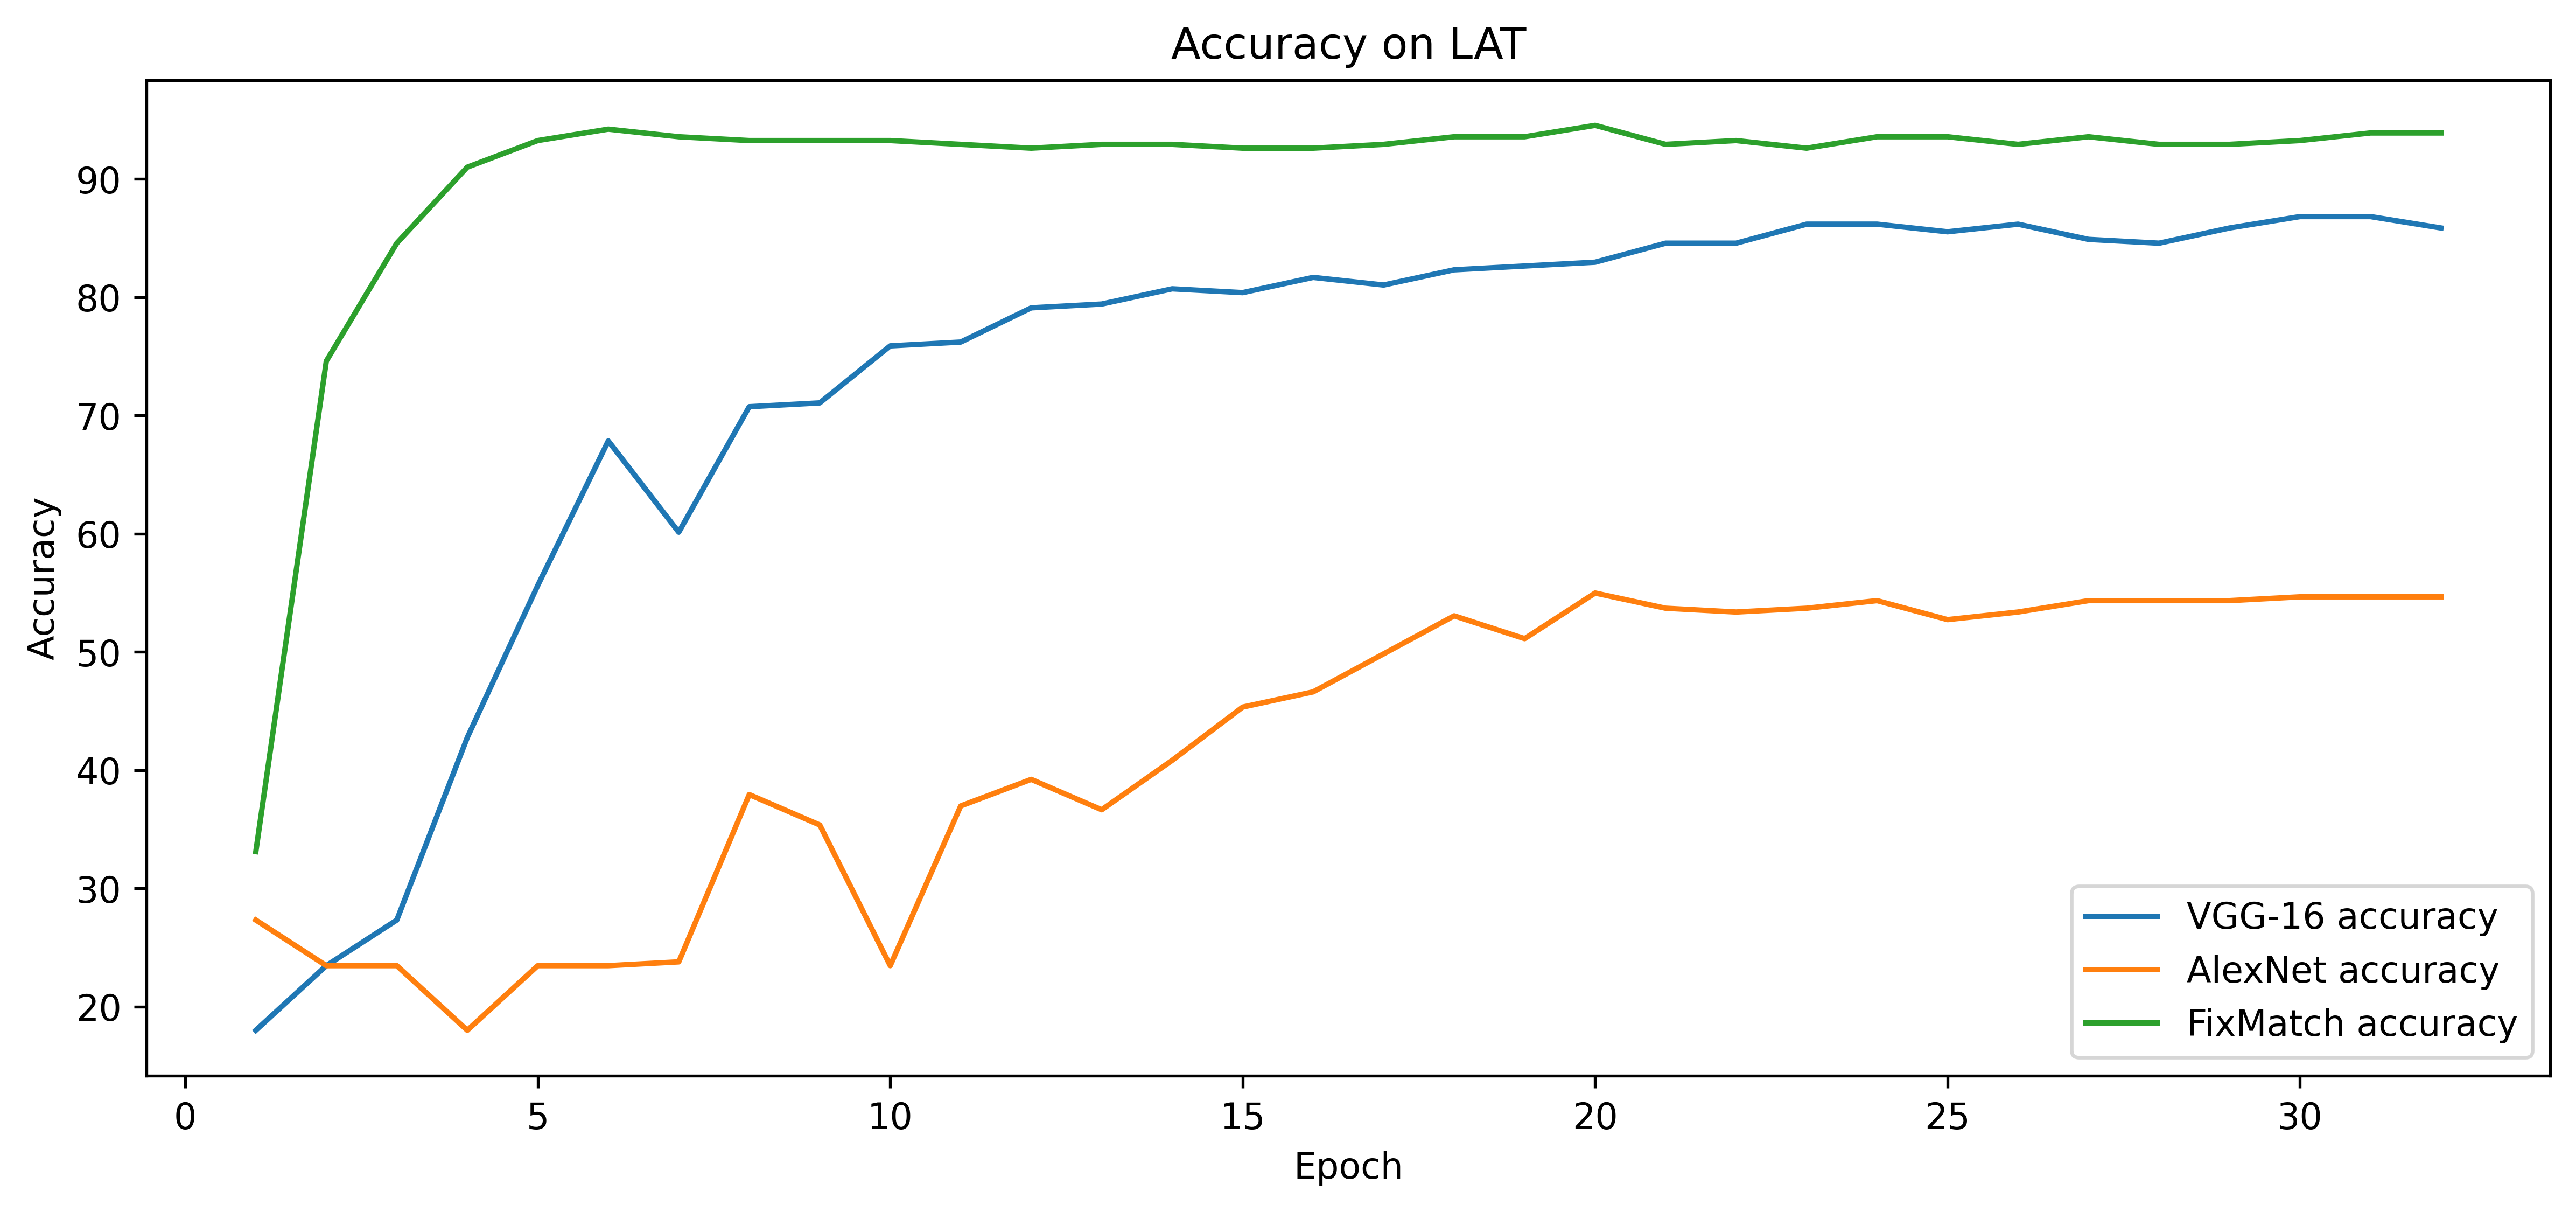

In [13]:
# python train.py --dataset lat --num-labeled 438 --arch wideresnet --batch-size 64 --lr 0.03 --expand-labels --seed 5 --out results/lat@400
import matplotlib.pyplot as plt

epoch = 32

file = open(os.path.join(GOOGLE_DRIVE_PATH,'output/vgg16_output.txt'), 'r')
vgg_acc_lst = eval(file.read())
vgg_acc_lst = [vgg_acc_lst[i] for i in range(0, len(vgg_acc_lst), 2)]
file.close()

file = open(os.path.join(GOOGLE_DRIVE_PATH,'output/alexnet_output.txt'), 'r')
alex_acc_lst = eval(file.read())
alex_acc_lst = [alex_acc_lst[i] for i in range(0, len(alex_acc_lst), 2)]
file.close()

file = open(os.path.join(GOOGLE_DRIVE_PATH,'output/fixmatch_output.txt'), 'r')
fixmatch_acc_lst = eval(file.read())
file.close()

plt.figure(dpi=480,figsize=(12,5))
# 训练精度和测试精度关系图
plt.plot(range(1, epoch + 1), vgg_acc_lst, label='VGG-16 accuracy')
plt.plot(range(1, epoch + 1), alex_acc_lst, label='AlexNet accuracy')
plt.plot(range(1, epoch + 1), fixmatch_acc_lst, label='FixMatch accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy on LAT")
plt.savefig('acc_epoch_{:04d}.png'.format(epoch))
plt.show()
plt.close()


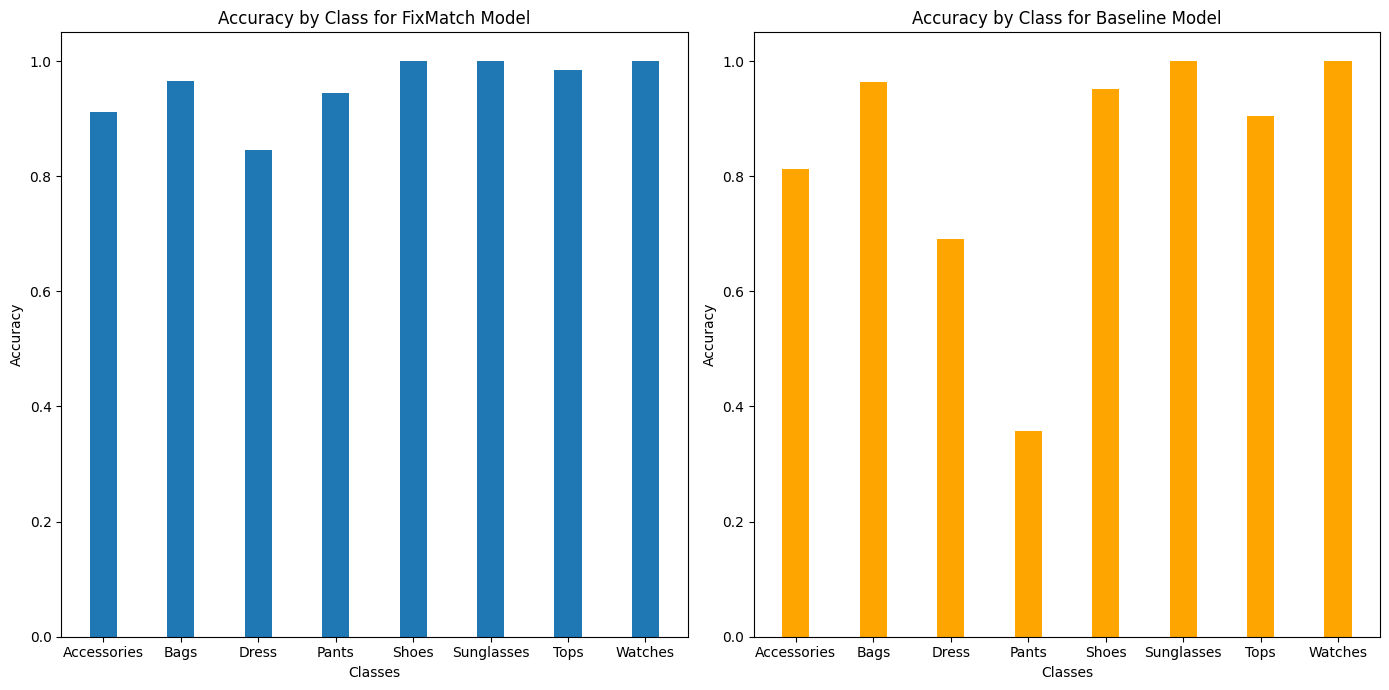

In [14]:
import numpy as np

fm_confusion_matrix=[[31,1,0,0,0,0,2,0],
                    [1,55,0,0,0,0,1,0],
                    [0,0,55,3,0,0,7,0],
                    [1,0,0,17,0,0,0,0],
                    [0,0,0,0,62,0,0,0],
                    [0,0,0,0,0,3,0,0],
                    [0,0,1,0,0,0,63,0],
                    [0,0,0,0,0,0,0,8]]
vgg_confusion_matrix=[[26,0,0,1,0,3,2,0],
                      [1,54,0,0,1,0,0,0],
                      [3,0,47,13,1,0,4,0],
                      [1,0,5,5,0,0,1,2],
                      [1,2,0,0,60,0,0,0],
                      [0,0,0,0,0,3,0,0],
                      [1,0,4,1,0,0,66,1],
                      [0,0,0,0,0,0,0,5]]

fm_confusion_matrix = np.array(fm_confusion_matrix)
vgg_confusion_matrix = np.array(vgg_confusion_matrix)

def calculate_accuracy_per_class(conf_matrix):
    accuracies = []
    for i in range(len(conf_matrix)):
        correct = conf_matrix[i, i]
        total = np.sum(conf_matrix[i])
        accuracy = correct / total if total != 0 else 0
        accuracies.append(accuracy)
    return accuracies

fm_accuracies = calculate_accuracy_per_class(fm_confusion_matrix)
vgg_accuracies = calculate_accuracy_per_class(vgg_confusion_matrix)

# 类别名称
class_names = ['Accessories', 'Bags', 'Dress', 'Pants',
               'Shoes', 'Sunglasses', 'Tops', 'Watches']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

x = np.arange(len(class_names))  # x轴的位置
width = 0.35  # 柱子的宽度

# 绘制FM模型的柱状图
rects1 = ax1.bar(x, fm_accuracies, width)
ax1.set_xlabel('Classes')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy by Class for FixMatch Model')
ax1.set_xticks(x)
ax1.set_xticklabels(class_names)

# 绘制VGG模型的柱状图
rects2 = ax2.bar(x, vgg_accuracies, width, color='orange')
ax2.set_xlabel('Classes')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Class for Baseline Model')
ax2.set_xticks(x)
ax2.set_xticklabels(class_names)

fig.tight_layout()
plt.savefig('acc_by_class.png'.format(epoch))
plt.show()
plt.close()